In [2]:
# import packages 
import zipfile
import tarfile
import io
import numpy as np
import pandas as pd
import json
import re
import plotly.express as px

# Inital Dataset Exploration

In [2]:
# See files within ZIP file

# Path to your ZIP file
zip_path = "Yelp-JSON.zip"

# Open the ZIP file and list file names
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_names = zip_ref.namelist()

# Print file names
print(file_names)

['Yelp JSON/', 'Yelp JSON/Yelp Dataset Documentation & ToS copy.pdf', '__MACOSX/Yelp JSON/._Yelp Dataset Documentation & ToS copy.pdf', 'Yelp JSON/yelp_dataset.tar', '__MACOSX/Yelp JSON/._yelp_dataset.tar']


In [2]:
# See files within dataset TAR file

# Path to your ZIP file
zip_path = "Yelp-JSON.zip"

# Open ZIP file and extract the TAR file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Find the first .tar file in the ZIP
    tar_file_name = [name for name in zip_ref.namelist() if name.endswith('.tar')][0]

    # Read the TAR file from the ZIP into memory
    with zip_ref.open(tar_file_name) as tar_bytes:
        tar_file = tarfile.open(fileobj=io.BytesIO(tar_bytes.read()))

        # List contents of the TAR file
        tar_contents = tar_file.getnames()
        print("Contents of TAR file:", tar_contents)

Contents of TAR file: ['Dataset_User_Agreement.pdf', 'yelp_academic_dataset_business.json', 'yelp_academic_dataset_checkin.json', 'yelp_academic_dataset_review.json', 'yelp_academic_dataset_tip.json', 'yelp_academic_dataset_user.json']


# Cleaning Restaurants Dataset

In [2]:
# Extracting dataframe from yelp_academic_dataset_business.json

# Path to your ZIP file
zip_path = "Yelp-JSON.zip"

# Open ZIP file without loading everything into memory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Find the first .tar file in the ZIP
    tar_file_name = next(name for name in zip_ref.namelist() if name.endswith('.tar'))

    # Open TAR file directly from ZIP without reading it all at once
    with zip_ref.open(tar_file_name) as tar_bytes, tarfile.open(fileobj=tar_bytes) as tar_file:
        # Find the first JSON file inside the TAR
        json_file_name = next(name for name in tar_file.getnames() if name.endswith('.json'))
        
        print(f"Extracting JSON file: {json_file_name}")

        # Open JSON file directly from the TAR archive (streaming, no full extraction)
        with tar_file.extractfile(json_file_name) as json_file:
            data_list = []  # Collect JSON objects into a list
            
            for line in json_file:  # Read each line of the JSON file
                json_data = line.decode('utf-8').strip()
                if not json_data:
                    continue  # Skip empty lines
                
                try:
                    parsed_json = json.loads(json_data)  # Parse JSON line
                    data_list.append(parsed_json)  # Append to list
                except json.JSONDecodeError as e:
                    print(f"Skipping invalid JSON line: {e}")
            
            # Convert to DataFrame once after collecting all data
            df = pd.DataFrame(data_list)
            
            # Filter to businesses in Pennsylvania 
            if 'state' in df.columns and 'PA' in df['state'].unique():
                df = df[df['state'] == 'PA']

print("Done")

Extracting JSON file: yelp_academic_dataset_business.json
Done


In [42]:
# Clean dataset

# clean and subset philadelphia businesses 
df['city'] = df['city'].str.lower()
philly_df = df[df['city'].str.contains('phil')]
philly_df['city']='Philadelphia'

# subset restaurants
philly_rest = philly_df[philly_df['categories'].str.contains('restaurant', na=False, case=False)]

# expand json in attributes 
philly_rest = philly_rest.join(pd.json_normalize(df["attributes"])).drop(columns=["attributes"])

# subset to restaurants that have price category 
philly_rest = philly_rest.loc[philly_rest['RestaurantsPriceRange2'].notnull()]

/tmp/ipykernel_975427/2699315166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  philly_df['city']='Philadelphia'


In [43]:
# Rename columns
philly_rest['price_level'] = philly_rest['RestaurantsPriceRange2']

# Drop unecessary columns 
columns = ['is_open', 'categories', 'hours','RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 
           'BusinessParking', 'BikeParking', 'RestaurantsTakeOut', 'ByAppointmentOnly', 
           'WiFi', 'Alcohol', 'Caters', 'WheelchairAccessible', 'GoodForKids', 
           'RestaurantsReservations', 'RestaurantsGoodForGroups',
           'RestaurantsAttire', 'HasTV', 'Ambience', 'GoodForMeal', 'NoiseLevel',
           'DogsAllowed', 'HappyHour', 'RestaurantsTableService', 'Smoking',
           'Music', 'GoodForDancing', 'BusinessAcceptsBitcoin', 'AcceptsInsurance',
           'CoatCheck', 'BYOB', 'BestNights', 'DriveThru', 'Corkage',
           'BYOBCorkage', 'HairSpecializesIn', 'Open24Hours', 'AgesAllowed',
           'DietaryRestrictions', 'RestaurantsCounterService', 'RestaurantsPriceRange2']
philly_rest.drop(columns, axis=1, inplace=True)

In [44]:
philly_rest.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,price_level
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,3
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1
28,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,1
35,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,2


### Column Explanation:
- price_level: 1-4, 1 is lowest, 4 is highest

In [45]:
# Export csv
philly_rest.to_csv('philly_restaurants.csv', index=False)

# Cleaning Review Dataset

In [3]:
# Get business ids from philly_restaurants.csv
philly_rest = pd.read_csv("philly_restaurants.csv", low_memory=False)
ids = philly_rest['business_id'].unique()

In [7]:
# Extracting dataframe from yelp_academic_dataset_review.json

# Path to your ZIP file
zip_path = "Yelp-JSON.zip"

# Open ZIP file without loading everything into memory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Find the first .tar file in the ZIP
    tar_file_name = next(name for name in zip_ref.namelist() if name.endswith('.tar'))

    # Open TAR file directly from ZIP without reading it all at once
    with zip_ref.open(tar_file_name) as tar_bytes, tarfile.open(fileobj=tar_bytes) as tar_file:
        # Find review dataset within the TAR
        json_file_name = 'yelp_academic_dataset_review.json'
        print(f"Extracting JSON file: {json_file_name}")

        # Open JSON file directly from the TAR archive (streaming, no full extraction)
        with tar_file.extractfile(json_file_name) as json_file:
            data_list = []  # Collect JSON objects into a list
            
            for line in json_file:  # Read each line of the JSON file
                json_data = line.decode('utf-8').strip()
                if not json_data:
                    continue  # Skip empty lines
                
                try:
                    parsed_json = json.loads(json_data)  # Parse JSON line
                    data_list.append(parsed_json)  # Append to list
                except json.JSONDecodeError as e:
                    print(f"Skipping invalid JSON line: {e}")
            
            # Convert to DataFrame once after collecting all data
            df = pd.DataFrame(data_list)
            
            # Filter to restaurants in Pennsylvania 
            df = df[df["business_id"].isin(ids)]

print("Done")

Extracting JSON file: yelp_academic_dataset_review.json
Done


In [17]:
# Drop unnecessary columns
cols = ['user_id','useful','funny','cool']
df.drop(cols, axis=1, inplace=True)

In [18]:
df.head()

,review_id,business_id,stars,text,date
13,8JFGBuHMoiNDyfcxuWNtrA,RZtGWDLCAtuipwaZ-UfjmQ,4.0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14
16,oyaMhzBSwfGgemSGuZCdwQ,YtSqYv1Q_pOltsVPSx54SA,5.0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25
19,Xs8Z8lmKkosqW5mw_sVAoA,eFvzHawVJofxSnD7TgbZtg,5.0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27
49,cvQXRFLCyr0S7EgFb4lZqw,EtKSTHV5Qx_Q7Aur9o4kQQ,5.0,"On a scale of one to things that are awesome, ...",2009-10-14 01:15:04
51,r2IBPY_E8AE5_GpsqlONyg,VJEzpfLs_Jnzgqh5A_FVTg,4.0,It was my fiance's birthday and he decided he ...,2014-04-01 13:05:18


In [19]:
# Export csv
df.to_csv("philly_reviews.csv", index=False)

# Exploratory Plots

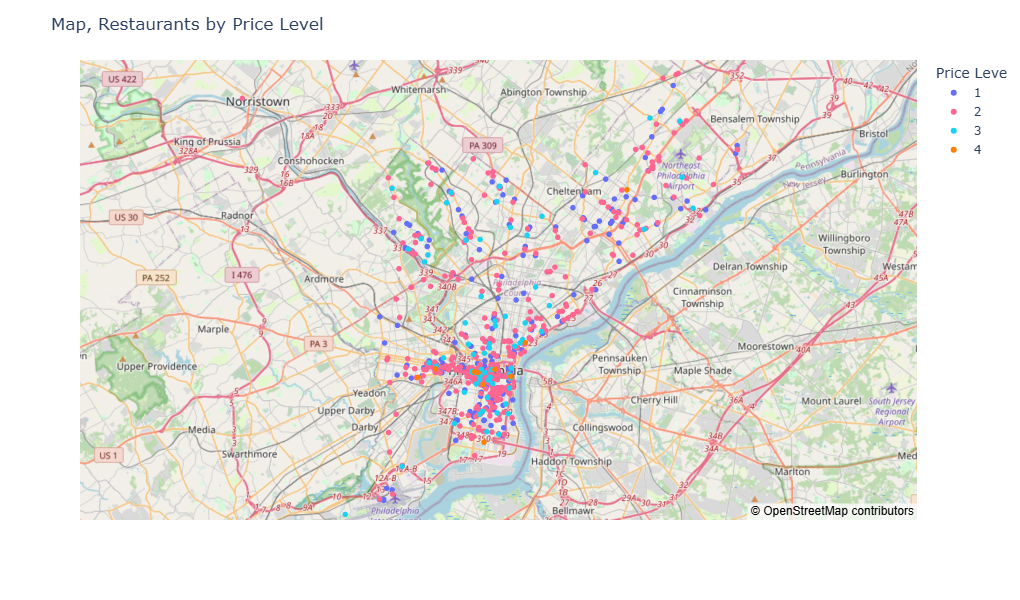

In [56]:
# Define a specific order for the legend
price_order = [1,2,3,4]

# Create a scatter map for restaurants by price level
philly_rest['price_level'] = philly_rest['price_level'].astype(object)
fig = px.scatter_mapbox(
    philly_rest, 
    lat="latitude", 
    lon="longitude", 
    hover_name="name",
    color='price_level',
    color_discrete_map={1: '#636EFA', 2: '#FF6692', 3:'#19D3F3', 4:'rgb(255,127,0)'},
    category_orders={"price_level": price_order},
    height=600,
    labels={'price_level': 'Price Level'}
)

# Use an OpenStreetMap (OSM) base map and add title
fig.update_layout(
    title= 'Map, Restaurants by Price Level',
    mapbox_style="open-street-map")

# Set map center and zoom level
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": philly_rest["latitude"].mean()+.025, "lon": philly_rest["longitude"].mean()},  # Center on mean location
    mapbox_zoom=9.8 # Adjust zoom level
)

# Show the map
fig.show()

In [57]:
# Save as PNG
fig.write_image("restaurant_map_by_price.png")